<a href="https://colab.research.google.com/github/Harika-Dachuri/Data_Science_Project/blob/main/Harika_final_file_with_changes_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the dataset
df = pd.read_csv('/content/Sales_Tax_Allocation__City.csv')
print(f"Dataset loaded successfully: {df.shape[0]:,} records, {df.shape[1]} features")

Dataset loaded successfully: 175,162 records, 10 features


In [ ]:
print(f"\n Basic Dataset Information")
print(f"Dataset Shape: {df.shape}")
print(f"Total Records: {df.shape[0]:,}")
print(f"Total Features: {df.shape[1]:,}")


 Basic Dataset Information
Dataset Shape: (175162, 10)
Total Records: 175,162
Total Features: 10


In [ ]:
print(f"\n Column Information")
for i, (col, dtype) in enumerate(zip(df.columns, df.dtypes), 1):
    print(f"{i:2d}. {col:<30} | {str(dtype):<15}")


 Column Information
 1. City                           | object         
 2. Net Payment This Period        | float64        
 3. Comparable Payment Prior Year  | float64        
 4. Percent Change From Prior Year | float64        
 5. Payment to Date                | float64        
 6. Previous Payments to Date      | float64        
 7. Percent Change To Date         | float64        
 8. Report Month                   | int64          
 9. Report Year                    | int64          
10. Report Period Type             | object         


In [ ]:
print(f"\n Sample Data Preview")
df.head()


 Sample Data Preview


,City,Net Payment This Period,Comparable Payment Prior Year,Percent Change From Prior Year,Payment to Date,Previous Payments to Date,Percent Change To Date,Report Month,Report Year,Report Period Type
0,Abbott,14301.88,15919.41,-10.16,146889.53,152146.26,-3.45,11,2023,MONTHLY
1,Abernathy,23516.10,23987.13,-1.96,270303.69,256849.99,5.23,11,2023,MONTHLY
2,Abilene,5526055.82,5477084.93,0.89,57014074.04,53887697.25,5.80,11,2023,MONTHLY
3,Ackerly,8877.41,12792.00,-30.60,86833.38,139977.10,-37.96,11,2023,MONTHLY
4,Addison,1588208.70,1316545.16,20.63,15730647.58,14677334.92,7.17,11,2023,MONTHLY


In [ ]:
print(f"\n Missing Values Analysis")
missing_data = df.isnull().sum()
if missing_data.sum() == 0:
    print("No missing values found")
else:
    print("Missing values found:")
    for col, missing in missing_data[missing_data > 0].items():
        print(f"  {col}: {missing:,} missing values")


 Missing Values Analysis
Missing values found:
  Percent Change From Prior Year: 624 missing values
  Percent Change To Date: 455 missing values


In [ ]:
print(f"\n Duplicate Records Analysis")
duplicate_count = df.duplicated().sum()
print(f"Total duplicate records: {duplicate_count:,}")
print(f"Percentage of duplicates: {(duplicate_count/len(df))*100:.2f}%")


 Duplicate Records Analysis
Total duplicate records: 0
Percentage of duplicates: 0.00%


In [ ]:
print(f"\n Outlier Detection")
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns: {len(numerical_cols)}")

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"  {col:<30}: {len(outliers):,} outliers ({len(outliers)/len(df)*100:.1f}%)")


 Outlier Detection
Numerical columns: 8
  Net Payment This Period       : 25,482 outliers (14.5%)
  Comparable Payment Prior Year : 25,482 outliers (14.5%)
  Percent Change From Prior Year: 15,812 outliers (9.0%)
  Payment to Date               : 26,509 outliers (15.1%)
  Previous Payments to Date     : 26,545 outliers (15.2%)
  Percent Change To Date        : 16,560 outliers (9.5%)
  Report Month                  : 0 outliers (0.0%)
  Report Year                   : 0 outliers (0.0%)


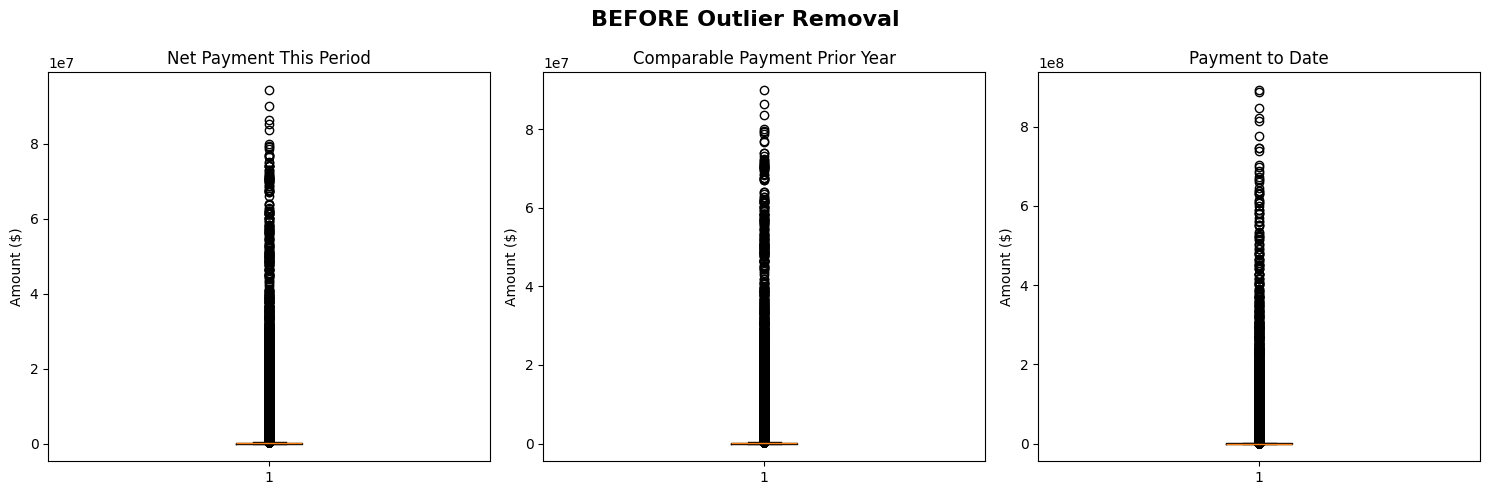

BEFORE: 175,162 records


In [ ]:
outlier_cols = ['Net Payment This Period', 'Comparable Payment Prior Year', 'Payment to Date']

plt.figure(figsize=(15, 5))
plt.suptitle('BEFORE Outlier Removal', fontsize=16, fontweight='bold')

for i, col in enumerate(outlier_cols, 1):
    plt.subplot(1, 3, i)
    plt.boxplot(df[col].dropna())
    plt.title(f'{col}')
    plt.ylabel('Amount ($)')

plt.tight_layout()
plt.show()
print(f"BEFORE: {len(df):,} records")

In [ ]:
print(f"\n Basic Statistical Summary")
df.describe()


 Basic Statistical Summary


,Net Payment This Period,Comparable Payment Prior Year,Percent Change From Prior Year,Payment to Date,Previous Payments to Date,Percent Change To Date,Report Month,Report Year
count,1.751620e+05,1.751620e+05,174538.000000,1.751620e+05,1.751620e+05,174707.000000,175162.000000,175162.000000
mean,4.671263e+05,4.417833e+05,17.055508,2.948576e+06,2.786281e+06,15.658289,6.384815,2018.828627
std,2.528416e+06,2.413829e+06,764.864249,1.805811e+07,1.721762e+07,1430.332351,3.438745,3.637856
min,0.000000e+00,0.000000e+00,-100.000000,0.000000e+00,0.000000e+00,-100.000000,1.000000,2013.000000
25%,7.199590e+03,6.599312e+03,-3.830000,3.496561e+04,3.198752e+04,-0.580000,3.000000,2016.000000
50%,3.152447e+04,2.952649e+04,6.620000,1.715656e+05,1.596299e+05,6.690000,6.000000,2019.000000
75%,1.834566e+05,1.720998e+05,19.780000,1.003647e+06,9.391033e+05,16.150000,9.000000,2022.000000
max,9.434388e+07,8.995339e+07,304661.640000,8.928802e+08,8.928802e+08,588285.460000,12.000000,2025.000000


#EDA

Payment Amount Statistics:
  Net Payment This Period - Mean: $467,126.26
  Net Payment This Period - Median: $31,524.47
  Comparable Payment Prior Year - Mean: $441,783.31


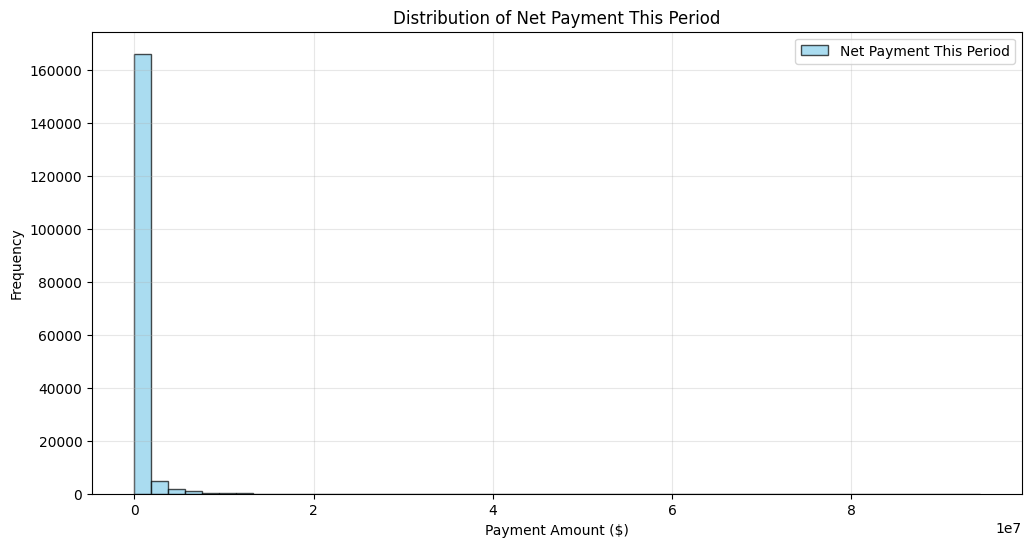

In [ ]:
# Payment amount distributions
print("Payment Amount Statistics:")
print(f"  Net Payment This Period - Mean: ${df['Net Payment This Period'].mean():,.2f}")
print(f"  Net Payment This Period - Median: ${df['Net Payment This Period'].median():,.2f}")
print(f"  Comparable Payment Prior Year - Mean: ${df['Comparable Payment Prior Year'].mean():,.2f}")

#Payment Amount Distributions
plt.figure(figsize=(12, 6))
plt.hist(df['Net Payment This Period'], bins=50, alpha=0.7, label='Net Payment This Period', color='skyblue', edgecolor='black')
plt.xlabel('Payment Amount ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Net Payment This Period')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

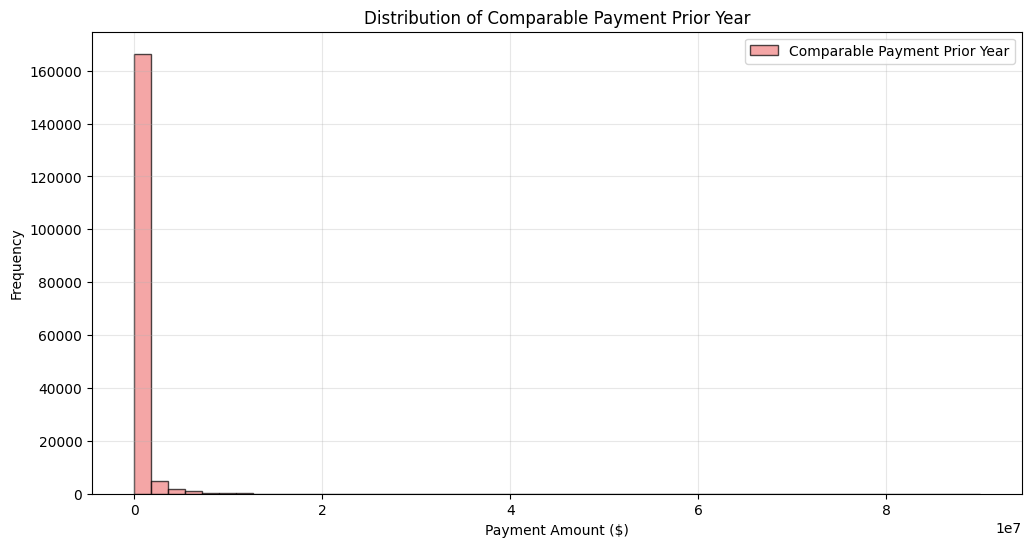

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(df['Comparable Payment Prior Year'], bins=50, alpha=0.7, label='Comparable Payment Prior Year', color='lightcoral', edgecolor='black')
plt.xlabel('Payment Amount ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Comparable Payment Prior Year')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

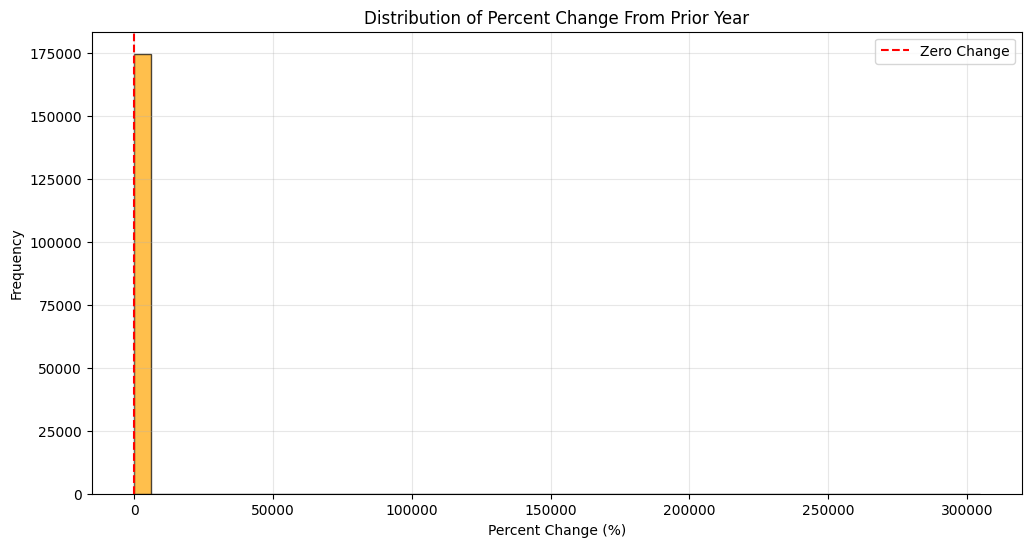

In [ ]:
# Percent Change Distribution
plt.figure(figsize=(12, 6))
plt.hist(df['Percent Change From Prior Year'], bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Percent Change (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Percent Change From Prior Year')
plt.axvline(x=0, color='red', linestyle='--', label='Zero Change')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [ ]:
# Create the missing variables for temporal analysis
year_counts = df['Report Year'].value_counts().sort_index()
month_counts = df['Report Month'].value_counts().sort_index()
top_cities = df['City'].value_counts().head(10)

# Also create variables for payment trend analysis
positive_changes = (df['Percent Change From Prior Year'] > 0).sum()
negative_changes = (df['Percent Change From Prior Year'] < 0).sum()
zero_changes = (df['Percent Change From Prior Year'] == 0).sum()


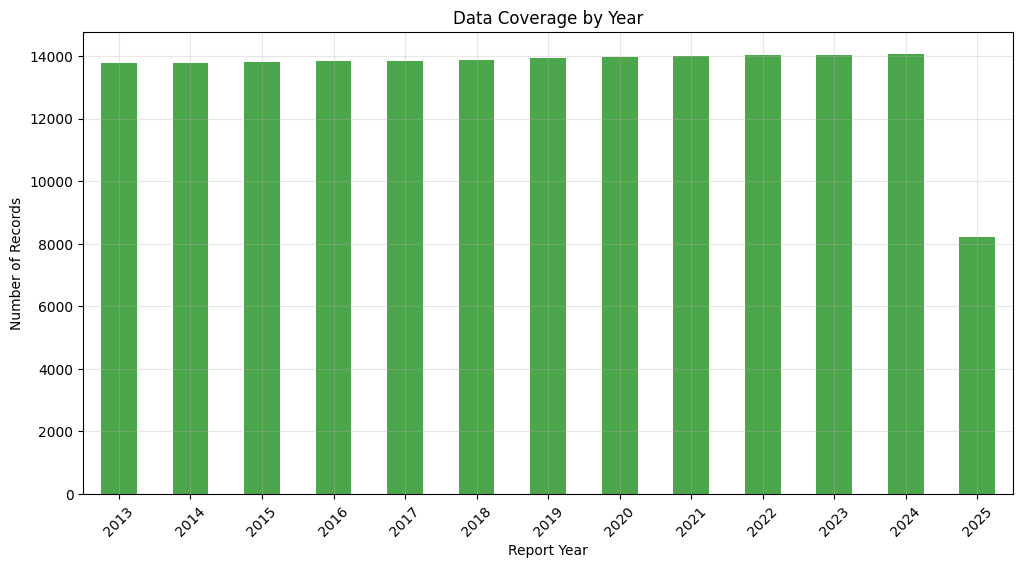

In [ ]:
# Temporal Distribution by Year
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar', color='green', alpha=0.7)
plt.xlabel('Report Year')
plt.ylabel('Number of Records')
plt.title('Data Coverage by Year')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()


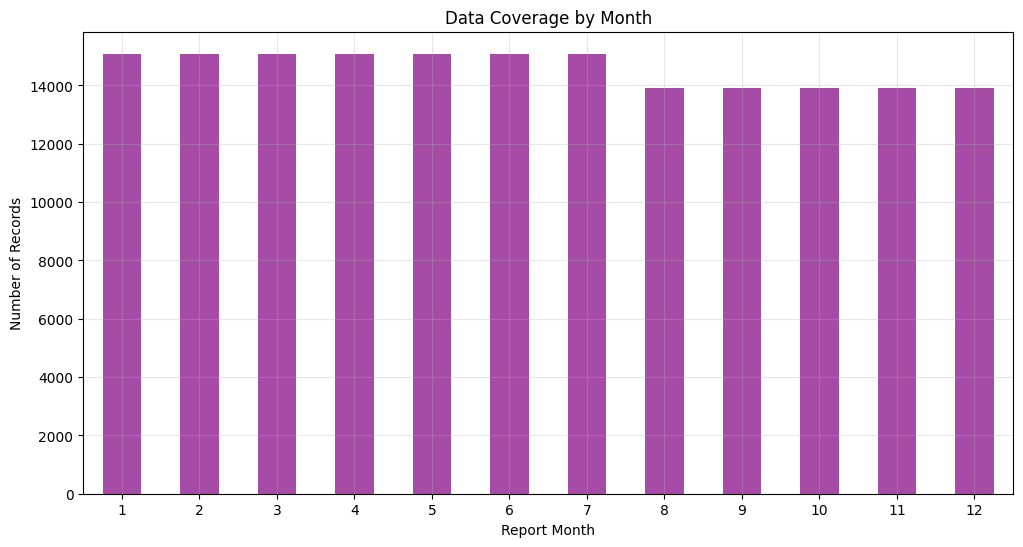

In [ ]:
# Create the month_counts variable from your dataframe
month_counts = df['Report Month'].value_counts().sort_index()

# Now you can plot it
plt.figure(figsize=(12, 6))
month_counts.plot(kind='bar', color='purple', alpha=0.7)
plt.xlabel('Report Month')
plt.ylabel('Number of Records')
plt.title('Data Coverage by Month')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()


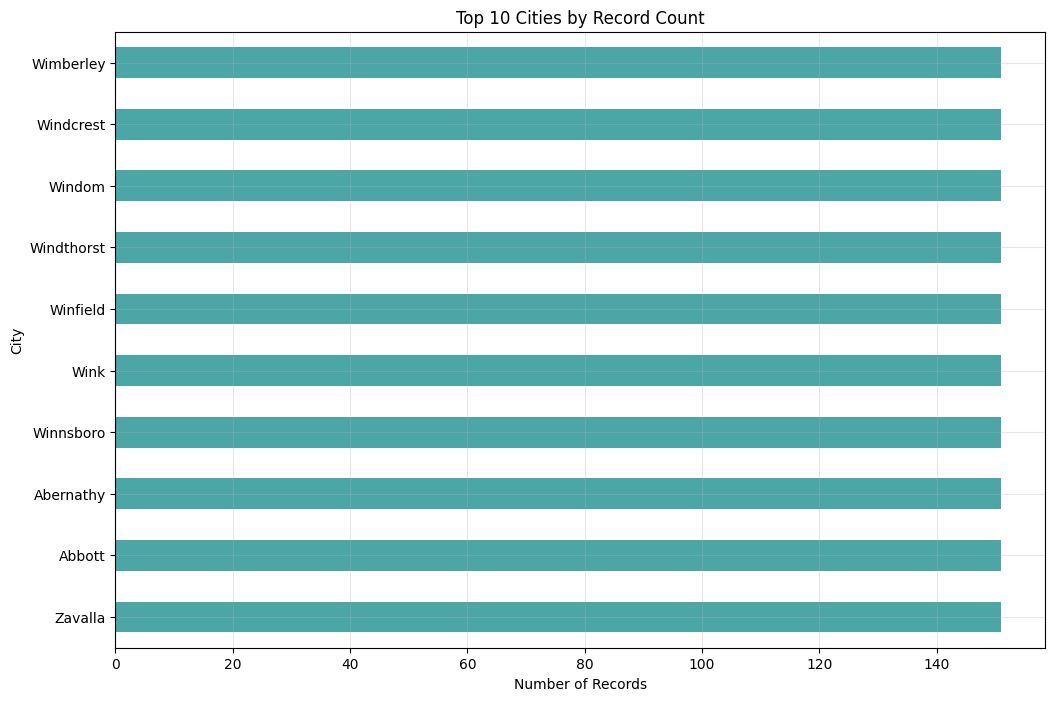

In [ ]:
# Create the top_cities variable from your dataframe
top_cities = df['City'].value_counts().head(10)

# Now you can plot it
plt.figure(figsize=(12, 8))
top_cities.plot(kind='barh', color='teal', alpha=0.7)
plt.xlabel('Number of Records')
plt.ylabel('City')
plt.title('Top 10 Cities by Record Count')
plt.grid(True, alpha=0.3)
plt.show()


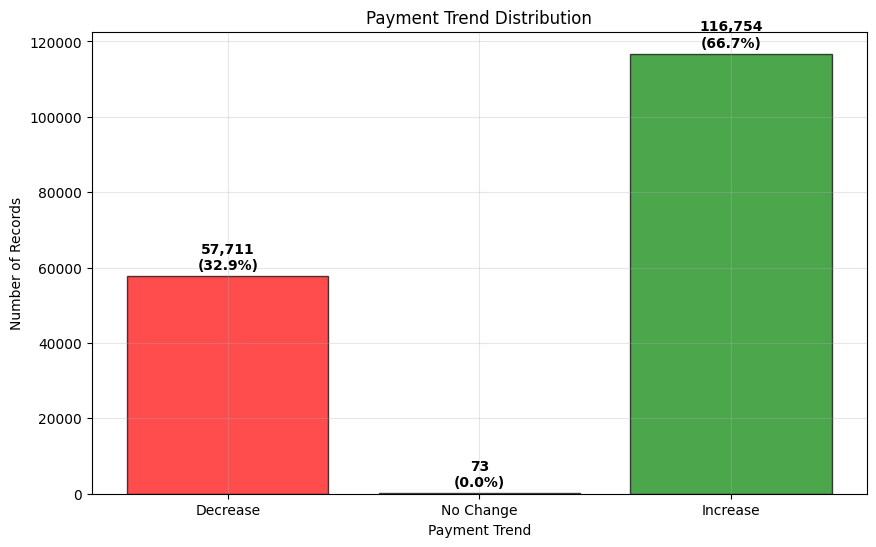

In [ ]:
# Create the payment trend variables from your dataframe
negative_changes = (df['Percent Change From Prior Year'] < 0).sum()
zero_changes = (df['Percent Change From Prior Year'] == 0).sum()
positive_changes = (df['Percent Change From Prior Year'] > 0).sum()

# Now you can create the plot
plt.figure(figsize=(10, 6))
trend_data = ['Decrease', 'No Change', 'Increase']
trend_counts = [negative_changes, zero_changes, positive_changes]
colors = ['red', 'gray', 'green']
plt.bar(trend_data, trend_counts, color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Payment Trend')
plt.ylabel('Number of Records')
plt.title('Payment Trend Distribution')
plt.grid(True, alpha=0.3)
for i, count in enumerate(trend_counts):
    plt.text(i, count + 1000, f'{count:,}\n({count/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')
plt.show()


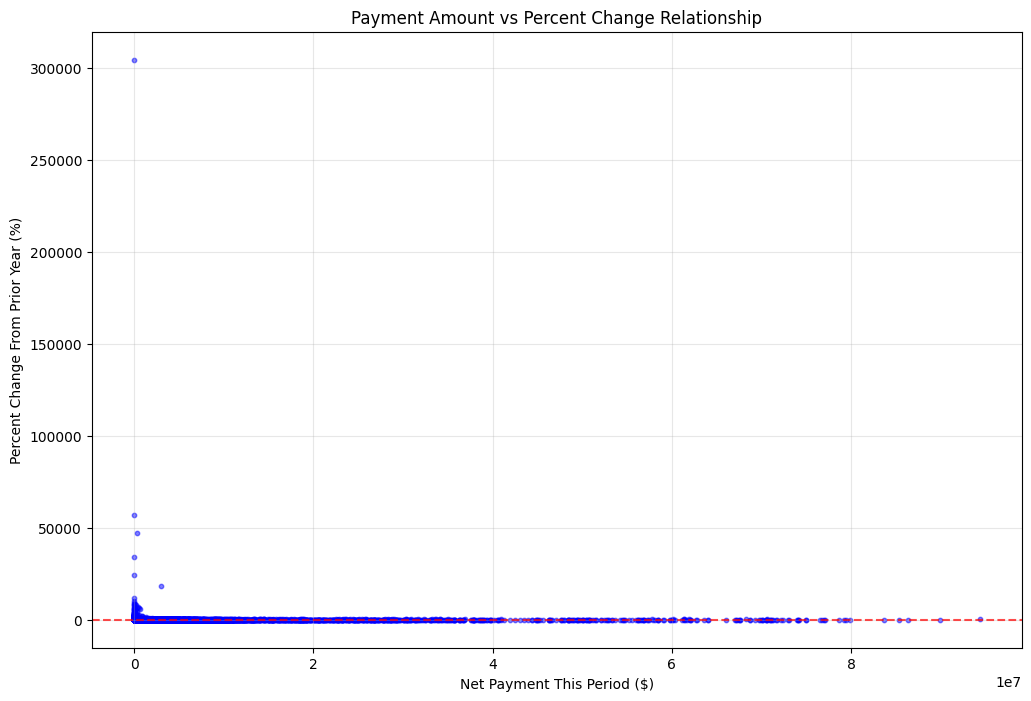

In [ ]:
# Payment Amount vs Percent Change Scatter Plot
plt.figure(figsize=(12, 8))
plt.scatter(df['Net Payment This Period'], df['Percent Change From Prior Year'],
           alpha=0.5, color='blue', s=10)
plt.xlabel('Net Payment This Period ($)')
plt.ylabel('Percent Change From Prior Year (%)')
plt.title('Payment Amount vs Percent Change Relationship')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)
plt.show()


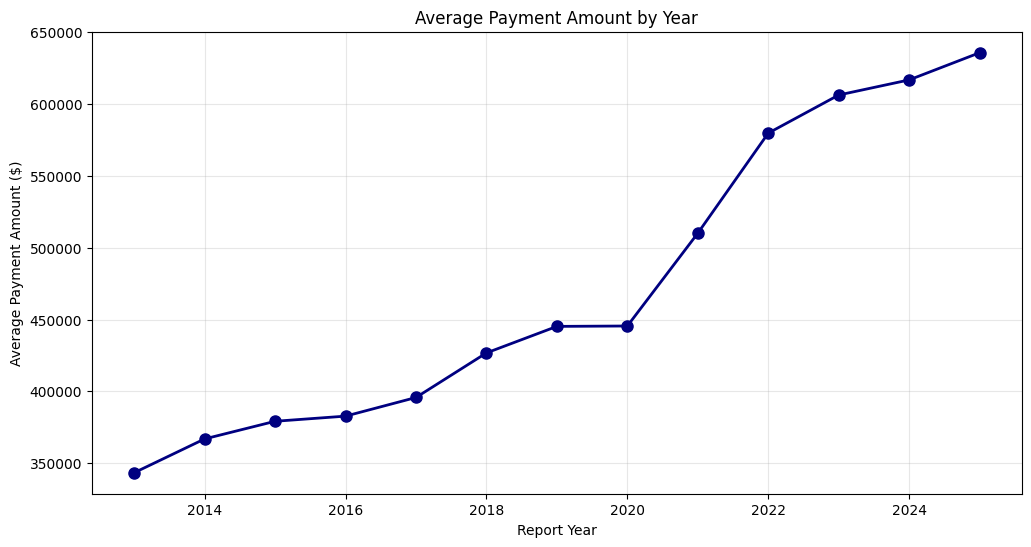

In [ ]:
#  Average Payment by Year
yearly_payments = df.groupby('Report Year')['Net Payment This Period'].mean()
plt.figure(figsize=(12, 6))
yearly_payments.plot(kind='line', marker='o', color='navy', linewidth=2, markersize=8)
plt.xlabel('Report Year')
plt.ylabel('Average Payment Amount ($)')
plt.title('Average Payment Amount by Year')
plt.grid(True, alpha=0.3)
plt.show()


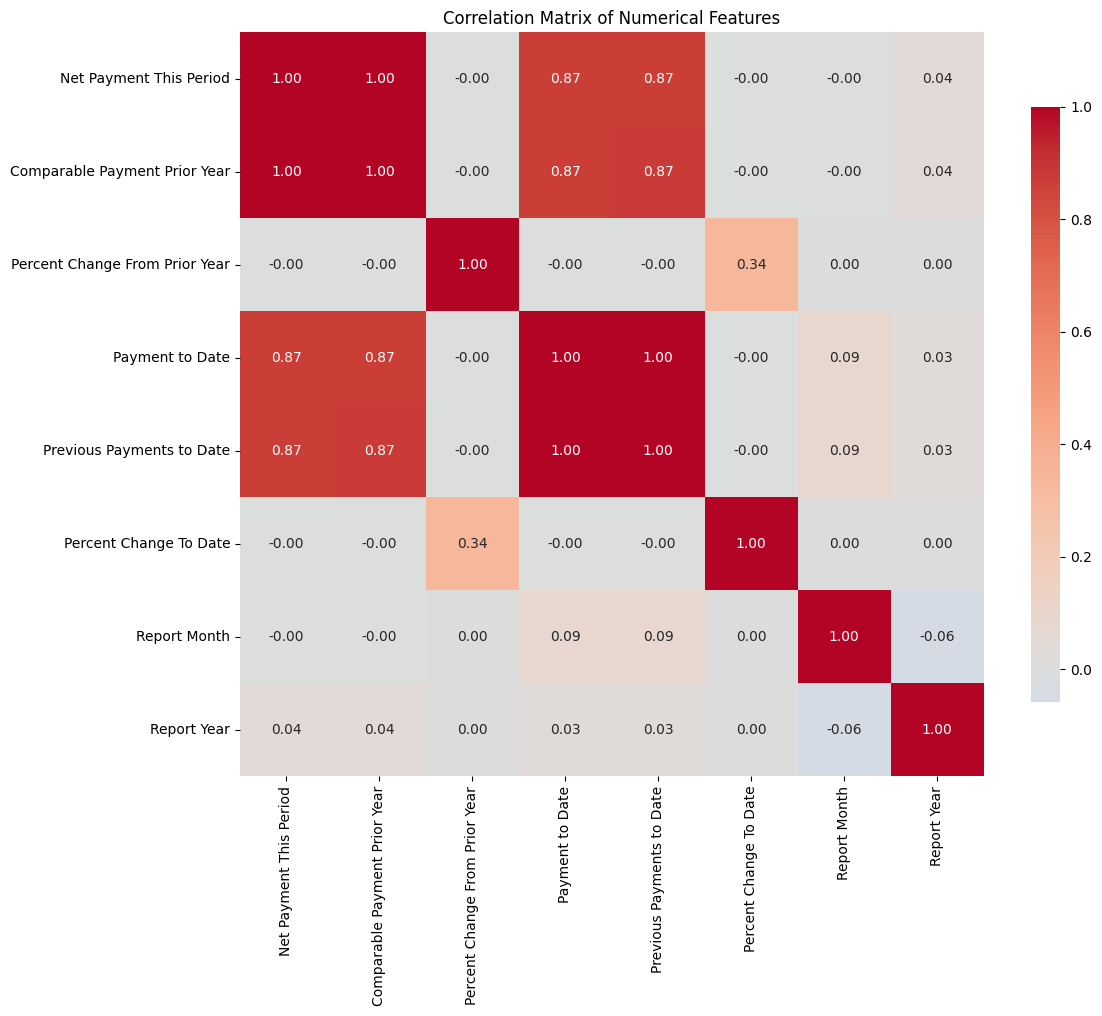

In [ ]:
# Correlation Matrix for Numerical Features
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

#Target variable


In [ ]:
# Create payment ratio
df['payment_ratio'] = df['Net Payment This Period'] / (df['Comparable Payment Prior Year'] + 1)

# Create default risk flag based on multiple criteria
df['default_risk'] = np.where(
    (df['Percent Change From Prior Year'] < -30) |
    (df['payment_ratio'] < 0.3), 1, 0
)

default_count = df['default_risk'].sum()
default_rate = df['default_risk'].mean()

print(f"Default risk criteria applied:")
print(f"  - Percent change from prior year < -30%")
print(f"  - Payment ratio < 0.3")
print(f"Default cases identified: {default_count:,}")
print(f"Default rate: {default_rate:.2%}")

Default risk criteria applied:
  - Percent change from prior year < -30%
  - Payment ratio < 0.3
Default cases identified: 8,130
Default rate: 4.64%


#feature engineering

In [ ]:
# Financial health indicators
df['payment_volatility'] = abs(df['Percent Change From Prior Year'])
df['payment_trend'] = np.where(df['Percent Change From Prior Year'] > 0, 1, 0)
df['large_payment'] = np.where(df['Net Payment This Period'] > df['Net Payment This Period'].median(), 1, 0)

# Temporal features
df['is_recent'] = np.where(df['Report Year'] >= 2020, 1, 0)

# Geographic risk features
city_default_rate = df.groupby('City')['default_risk'].mean()
df['city_risk_score'] = df['City'].map(city_default_rate)

# Report period encoding
le_period = LabelEncoder()
df['period_encoded'] = le_period.fit_transform(df['Report Period Type'])

print("Features created successfully")

Features created successfully


In [ ]:
print(f"\nHandling Missing Values")
missing_before = df.isnull().sum().sum()
print(f"Missing values before cleaning: {missing_before:,}")

df['Percent Change From Prior Year'] = df['Percent Change From Prior Year'].fillna(0)
df['Percent Change To Date'] = df['Percent Change To Date'].fillna(0)

missing_after = df.isnull().sum().sum()
print(f"Missing values after cleaning: {missing_after:,}")


Handling Missing Values
Missing values before cleaning: 1,703
Missing values after cleaning: 624


In [ ]:
print(f"\nRemoving Duplicate Records")
initial_records = len(df)
df = df.drop_duplicates()
final_records = len(df)
print(f"Records before: {initial_records:,}")
print(f"Records after: {final_records:,}")
print(f"Duplicates removed: {initial_records - final_records:,}")


Removing Duplicate Records
Records before: 175,162
Records after: 175,162
Duplicates removed: 0


In [ ]:
print(f"\nConservative Outlier Handling")
def remove_extreme_outliers(data, column, factor=4.0):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    before_count = len(data)
    data_cleaned = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    after_count = len(data_cleaned)
    print(f"  {column}: Removed {before_count - after_count:,} extreme outliers")
    return data_cleaned

outlier_columns = ['Net Payment This Period', 'Comparable Payment Prior Year', 'Payment to Date']
records_before_outlier = len(df)

for col in outlier_columns:
    if col in df.columns:
        df = remove_extreme_outliers(df, col, factor=4.0)

records_after_outlier = len(df)
print(f"Total records removed due to outliers: {records_before_outlier - records_after_outlier:,}")


Conservative Outlier Handling
  Net Payment This Period: Removed 15,745 extreme outliers
  Comparable Payment Prior Year: Removed 6,972 extreme outliers
  Payment to Date: Removed 7,844 extreme outliers
Total records removed due to outliers: 30,561


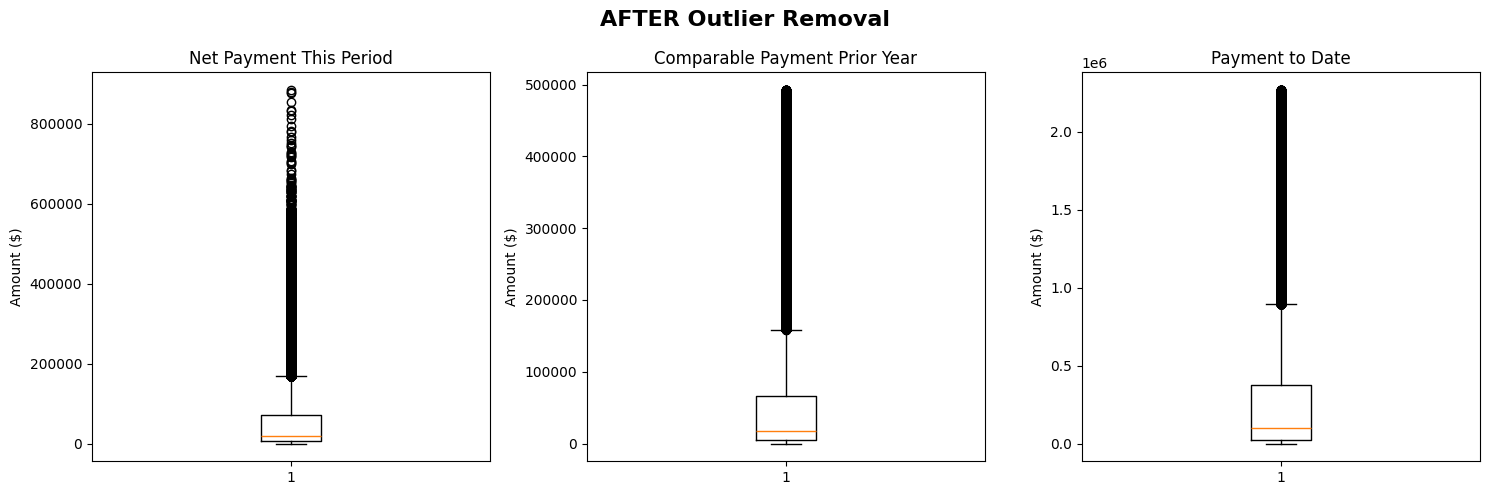

AFTER: 144,601 records
Removed: 30,561 records


In [ ]:
plt.figure(figsize=(15, 5))
plt.suptitle('AFTER Outlier Removal', fontsize=16, fontweight='bold')

for i, col in enumerate(outlier_cols, 1):
    plt.subplot(1, 3, i)
    plt.boxplot(df[col].dropna())
    plt.title(f'{col}')
    plt.ylabel('Amount ($)')

plt.tight_layout()
plt.show()
print(f"AFTER: {len(df):,} records")
print(f"Removed: {30561:,} records")

In [ ]:
print(f"\nFeature Selection")
feature_columns = [
    'Net Payment This Period', 'Comparable Payment Prior Year',
    'Percent Change From Prior Year', 'Payment to Date',
    'Report Month', 'Report Year', 'payment_ratio',
    'payment_volatility', 'payment_trend', 'large_payment',
    'is_recent', 'city_risk_score', 'period_encoded'
]

for col in feature_columns:
    if col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 0)

print(f"Final dataset shape: {df.shape}")
print(f"Features selected: {len(feature_columns)}")

# Prepare final dataset
X = df[feature_columns].copy()
y = df['default_risk'].copy()

mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"Final clean dataset: {len(X):,} records")


Feature Selection
Final dataset shape: (144601, 18)
Features selected: 13
Final clean dataset: 144,601 records


In [ ]:
print(f"\n Class Distribution Analysis")
class_distribution = y.value_counts()
print(f"Non-default (0): {class_distribution[0]:,} ({class_distribution[0]/len(y)*100:.1f}%)")
print(f"Default (1): {class_distribution[1]:,} ({class_distribution[1]/len(y)*100:.1f}%)")

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


 Class Distribution Analysis
Non-default (0): 136,878 (94.7%)
Default (1): 7,723 (5.3%)


In [ ]:
print(f"\n Train-Test Split")
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Training set class distribution:")
print(f"  Non-default (0): {(y_train == 0).sum():,} ({(y_train == 0).mean():.1f}%)")
print(f"  Default (1): {(y_train == 1).sum():,} ({(y_train == 1).mean():.1f}%)")

# Calculate class weights (using class weights)
print(f"\n Class Weight Calculation")
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights - Non-default: {class_weights[0]:.3f}, Default: {class_weights[1]:.3f}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully")
print("Using class weights")


 Train-Test Split
Training set: 115,680 samples
Test set: 28,921 samples
Training set class distribution:
  Non-default (0): 109,502 (0.9%)
  Default (1): 6,178 (0.1%)

 Class Weight Calculation
Class weights - Non-default: 0.528, Default: 9.362
Features scaled successfully
Using class weights


# LOGISTIC REGRESSION MODEL

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Logistic Regression
lr_model = LogisticRegression(
    random_state=42,
    class_weight='balanced',
    max_iter=1000,
    solver='liblinear',
    penalty='l2',
    C=0.1
)

print("Training Logistic Regression model...")
lr_model.fit(X_train_scaled, y_train)  # Use original training data
print("Logistic Regression training completed")

print(f"\nLogistic Regression Cross-Validation")
# Proper cross-validation on original data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
print(f"LR Cross-validation scores: {cv_scores_lr}")
print(f"LR Mean CV score: {cv_scores_lr.mean():.3f} (+/- {cv_scores_lr.std() * 2:.3f})")


Training Logistic Regression model...
Logistic Regression training completed

Logistic Regression Cross-Validation
LR Cross-validation scores: [0.90555844 0.90858402 0.90793568 0.90841113 0.90927559]
LR Mean CV score: 0.908 (+/- 0.003)


In [ ]:
print(f"\n Logistic Regression Evaluation")

# Make predictions
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
lr_pred = lr_model.predict(X_test_scaled)

# Calculate metrics
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred_proba)

print("Logistic Regression Performance:")
print(f"Accuracy:  {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")
print(f"AUC-ROC:   {lr_auc:.4f}")

# Confusion Matrix
lr_cm = confusion_matrix(y_test, lr_pred)
lr_tn, lr_fp, lr_fn, lr_tp = lr_cm.ravel()
print(f"\nLogistic Regression Confusion Matrix:")
print(f"True Negatives:  {lr_tn:,}")
print(f"False Positives: {lr_fp:,}")
print(f"False Negatives: {lr_fn:,}")
print(f"True Positives:  {lr_tp:,}")



 Logistic Regression Evaluation
Logistic Regression Performance:
Accuracy:  0.9155
Precision: 0.3872
Recall:    0.9981
F1-Score:  0.5580
AUC-ROC:   0.9921

Logistic Regression Confusion Matrix:
True Negatives:  24,936
False Positives: 2,440
False Negatives: 3
True Positives:  1,542


In [ ]:
print(f"\n Logistic Regression Evaluation")

# Make predictions
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
lr_pred = lr_model.predict(X_test_scaled)

# Calculate metrics
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred_proba)

print("Logistic Regression Performance:")
print(f"Accuracy:  {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")
print(f"AUC-ROC:   {lr_auc:.4f}")


 Logistic Regression Evaluation
Logistic Regression Performance:
Accuracy:  0.9155
Precision: 0.3872
Recall:    0.9981
F1-Score:  0.5580
AUC-ROC:   0.9921


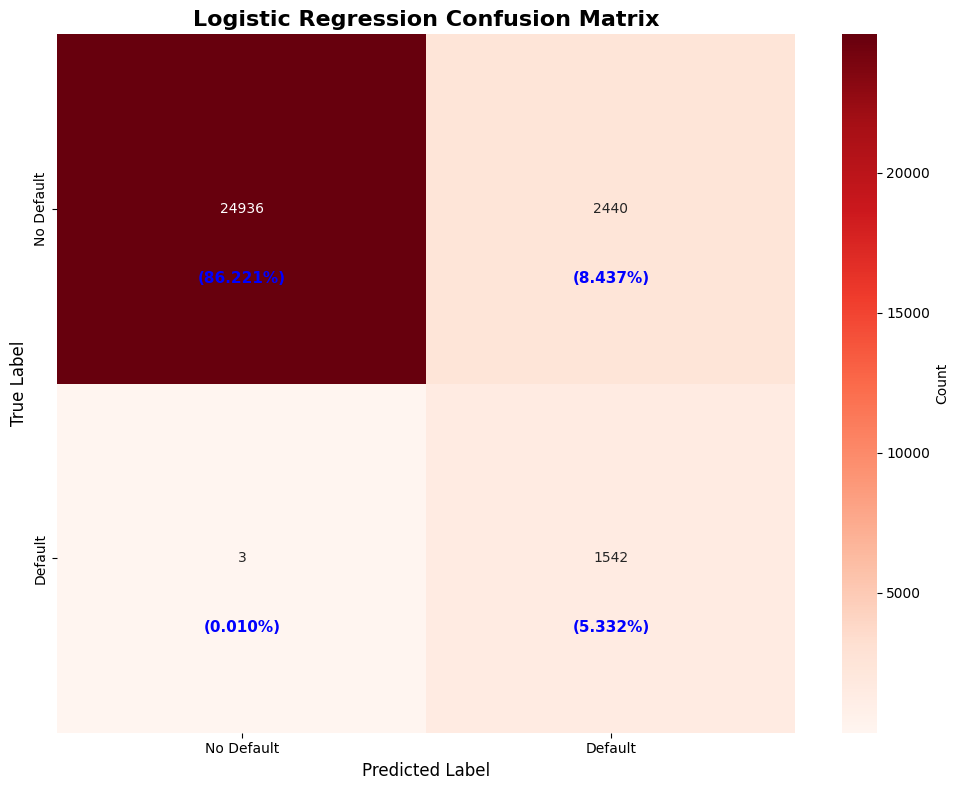

In [ ]:
# Visualize Logistic Regression Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'],
            cbar_kws={'label': 'Count'})

plt.title('Logistic Regression Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add percentage annotations with 3 decimal places
total_lr = np.sum(lr_cm)
for i in range(lr_cm.shape[0]):
    for j in range(lr_cm.shape[1]):
        percentage = lr_cm[i, j] / total_lr * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.3f}%)',
                 ha='center', va='center', fontsize=11, color='blue', fontweight='bold')

plt.tight_layout()
plt.show()


#NEURAL NETWORK MODEL

In [ ]:
# Neural Network with regularization
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],),
          kernel_regularizer=l2(0.01)),  # L2 regularization
    Dropout(0.5),  # Higher dropout
    Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("Model architecture:")
print(f"  Input layer: {X_train_scaled.shape[1]} features")
print("  Hidden layers: 16 -> 8 neurons")
print("  Output layer: 1 neuron (sigmoid activation)")
print("  Regularization: L2 + High Dropout")

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

Model architecture:
  Input layer: 13 features
  Hidden layers: 16 -> 8 neurons
  Output layer: 1 neuron (sigmoid activation)
  Regularization: L2 + High Dropout


In [ ]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7156 - loss: 0.6752 - precision: 0.1385 - recall: 0.7782 - val_accuracy: 0.8476 - val_loss: 0.3488 - val_precision: 0.2569 - val_recall: 0.9554
Epoch 2/100
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8219 - loss: 0.3883 - precision: 0.2211 - recall: 0.9138 - val_accuracy: 0.8319 - val_loss: 0.3591 - val_precision: 0.2433 - val_recall: 0.9944
Epoch 3/100
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8265 - loss: 0.3511 - precision: 0.2291 - recall: 0.9400 - val_accuracy: 0.8759 - val_loss: 0.3026 - val_precision: 0.3003 - val_recall: 0.9681
Epoch 4/100
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8379 - loss: 0.3269 - precision: 0.2377 - recall: 0.9449 - val_accuracy: 0.8352 - val_loss: 0.3311 - val_precision: 0.2475 - val_recall: 0.9992
Epoch 5/100
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8288 - loss: 0.3085 - precision: 0.2268 - recall: 0.9591 - val_accuracy: 0.8308

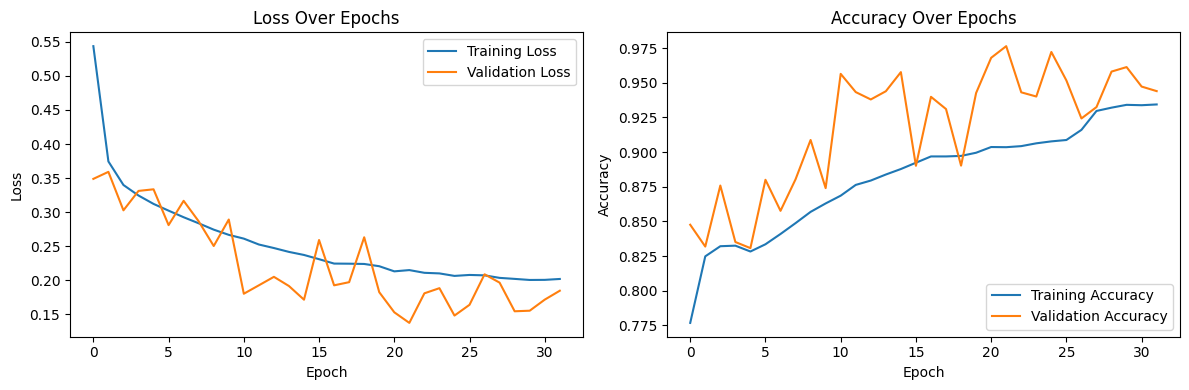

In [ ]:
# Plot loss over epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Make predictions
y_pred_proba = model.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("Neural Network Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

Neural Network Performance:
Accuracy:  0.9741
Precision: 0.6767
Recall:    0.9877
F1-Score:  0.8032
AUC-ROC:   0.9969


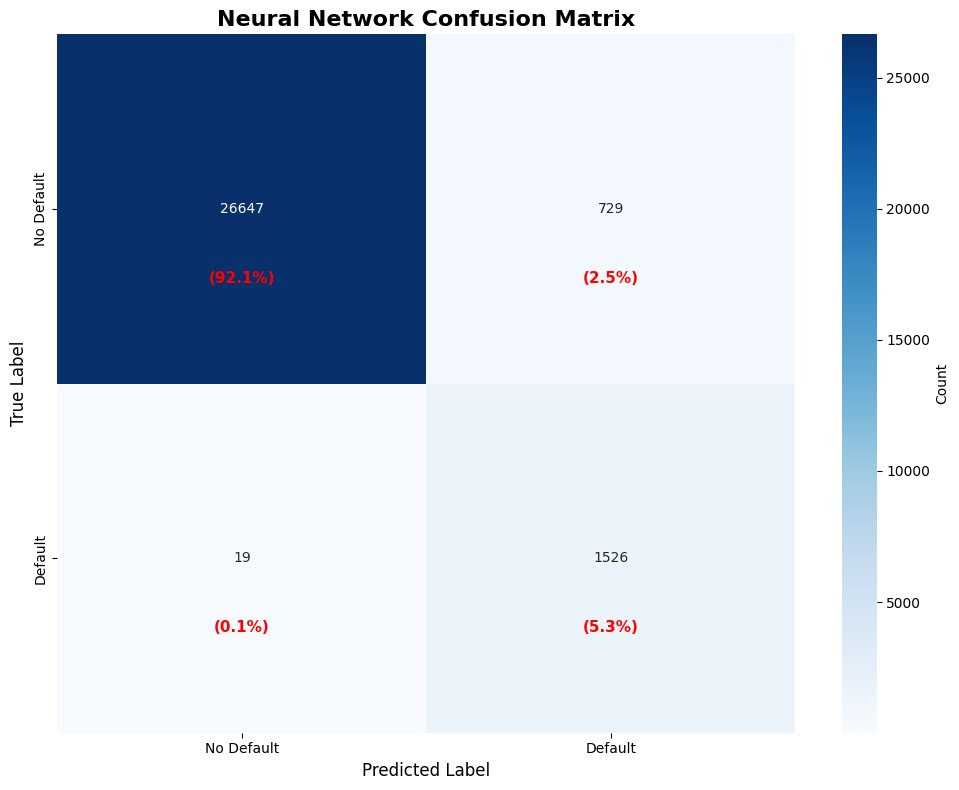

In [ ]:
# Visualize Neural Network Confusion Matrix
# Create the confusion matrix for Neural Network
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'],
            cbar_kws={'label': 'Count'})

plt.title('Neural Network Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add percentage annotations
total = np.sum(cm)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        percentage = cm[i, j] / total * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                ha='center', va='center', fontsize=11, color='red', fontweight='bold')

plt.tight_layout()
plt.show()

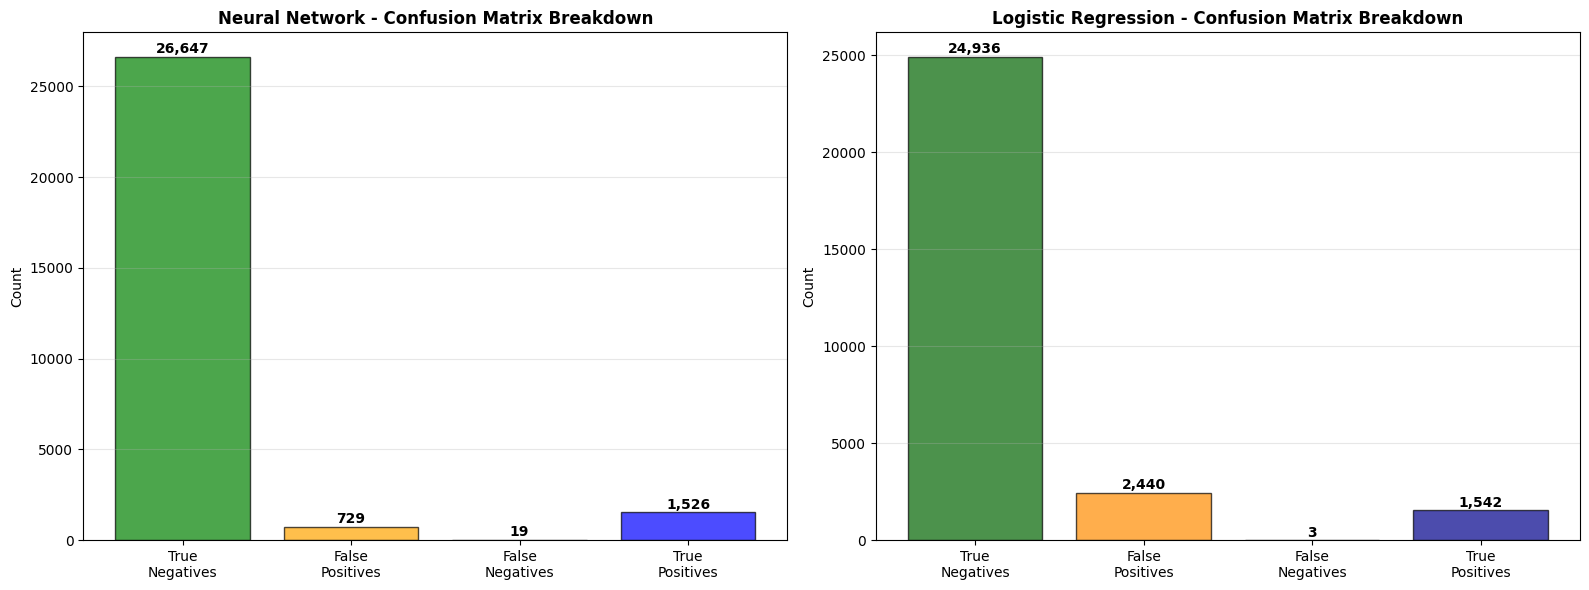

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Neural Network Breakdown
nn_categories = ['True\nNegatives', 'False\nPositives', 'False\nNegatives', 'True\nPositives']
nn_values = [tn, fp, fn, tp]
colors_nn = ['green', 'orange', 'red', 'blue']

bars1 = ax1.bar(nn_categories, nn_values, color=colors_nn, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Count')
ax1.set_title('Neural Network - Confusion Matrix Breakdown', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels for NN
for bar, value in zip(bars1, nn_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 20, f'{value:,}',
             ha='center', va='bottom', fontweight='bold')

# Logistic Regression Breakdown
lr_categories = ['True\nNegatives', 'False\nPositives', 'False\nNegatives', 'True\nPositives']
lr_values = [lr_tn, lr_fp, lr_fn, lr_tp]
colors_lr = ['darkgreen', 'darkorange', 'darkred', 'darkblue']

bars2 = ax2.bar(lr_categories, lr_values, color=colors_lr, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Count')
ax2.set_title('Logistic Regression - Confusion Matrix Breakdown', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels for LR
for bar, value in zip(bars2, lr_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 20, f'{value:,}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Create comparison dataframe
model_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'Neural_Network': [accuracy, precision, recall, f1, auc],
    'Logistic_Regression': [lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc]
})

print("Neural Network vs Logistic Regression Performance:")
print(model_comparison.round(4))

# Determine better performing model
nn_avg = model_comparison['Neural_Network'].mean()
lr_avg = model_comparison['Logistic_Regression'].mean()
better_model = "Neural Network" if nn_avg > lr_avg else "Logistic Regression"
print(f"\nBetter performing model: {better_model}")
print(f"Neural Network average score: {nn_avg:.4f}")
print(f"Logistic Regression average score: {lr_avg:.4f}")

print(f"\n1 Cross-Validation Comparison")
print(f"Logistic Regression CV: {cv_scores_lr.mean():.3f} (+/- {cv_scores_lr.std() * 2:.3f})")
print("Neural Network: No CV (due to computational complexity)")


Neural Network vs Logistic Regression Performance:
      Metric  Neural_Network  Logistic_Regression
0   Accuracy          0.9741               0.9155
1  Precision          0.6767               0.3872
2     Recall          0.9877               0.9981
3   F1-Score          0.8032               0.5580
4    AUC-ROC          0.9969               0.9921

Better performing model: Neural Network
Neural Network average score: 0.8877
Logistic Regression average score: 0.7702

1 Cross-Validation Comparison
Logistic Regression CV: 0.908 (+/- 0.003)
Neural Network: No CV (due to computational complexity)


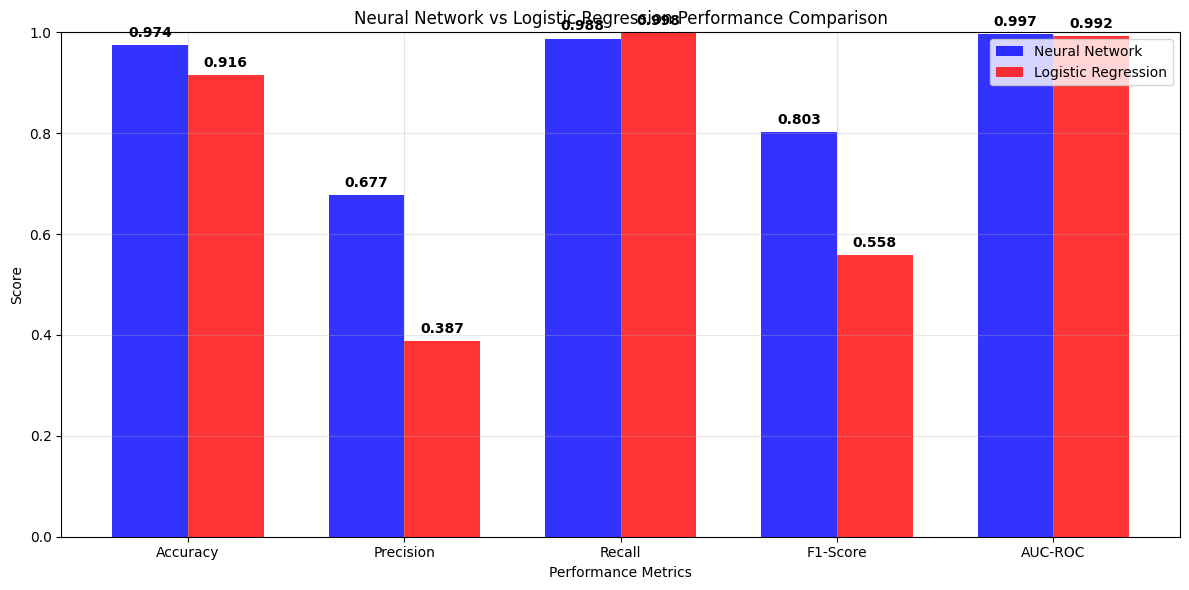

In [ ]:
# Performance Comparison Chart
plt.figure(figsize=(12, 6))
x = np.arange(len(model_comparison['Metric']))
width = 0.35

plt.bar(x - width/2, model_comparison['Neural_Network'], width,
        label='Neural Network', alpha=0.8, color='blue')
plt.bar(x + width/2, model_comparison['Logistic_Regression'], width,
        label='Logistic Regression', alpha=0.8, color='red')

plt.xlabel('Performance Metrics')
plt.ylabel('Score')
plt.title('Neural Network vs Logistic Regression Performance Comparison')
plt.xticks(x, model_comparison['Metric'])
plt.legend()
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Add value labels
for i, (nn_val, lr_val) in enumerate(zip(model_comparison['Neural_Network'],
                                        model_comparison['Logistic_Regression'])):
    plt.text(i - width/2, nn_val + 0.01, f'{nn_val:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.text(i + width/2, lr_val + 0.01, f'{lr_val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


ROC Curves Comparison


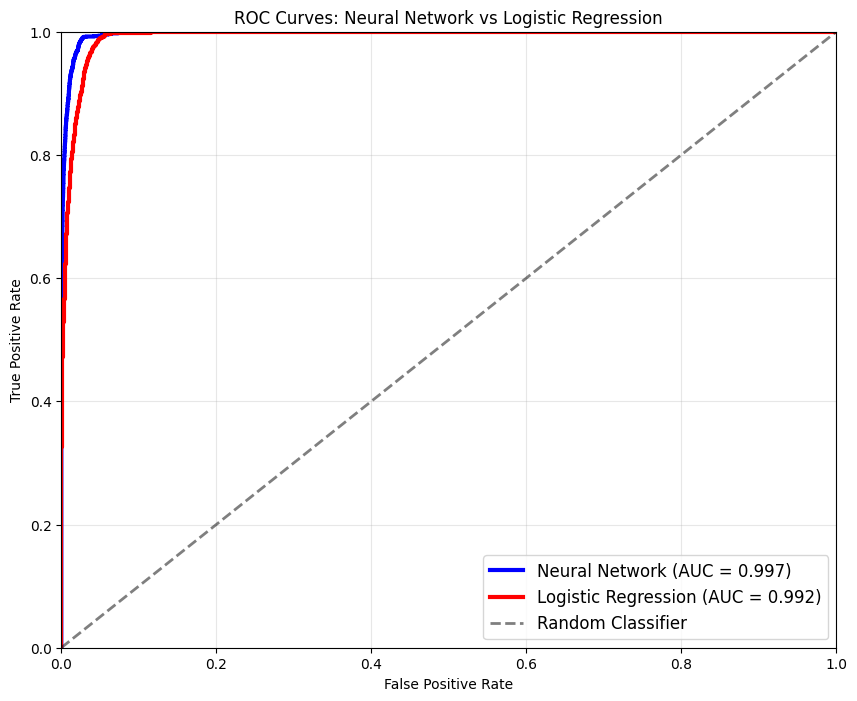

In [ ]:
print(f"\nROC Curves Comparison")

# ROC Curves
plt.figure(figsize=(10, 8))

# Neural Network ROC
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc:.3f})',
         linewidth=3, color='blue')

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pred_proba)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_auc:.3f})',
         linewidth=3, color='red')

# Random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5, linewidth=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Neural Network vs Logistic Regression')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

Top 10 Most Important Features (Logistic Regression):
 3. Percent Change From Prior Year: -15.8383
 8. payment_volatility            : 15.7545
 1. Net Payment This Period       : -14.6771
 2. Comparable Payment Prior Year : 10.2815
 9. payment_trend                 : -2.6861
 7. payment_ratio                 : -2.1670
12. city_risk_score               : 0.6161
 4. Payment to Date               : -0.3763
 6. Report Year                   : -0.1952
10. large_payment                 : -0.1253


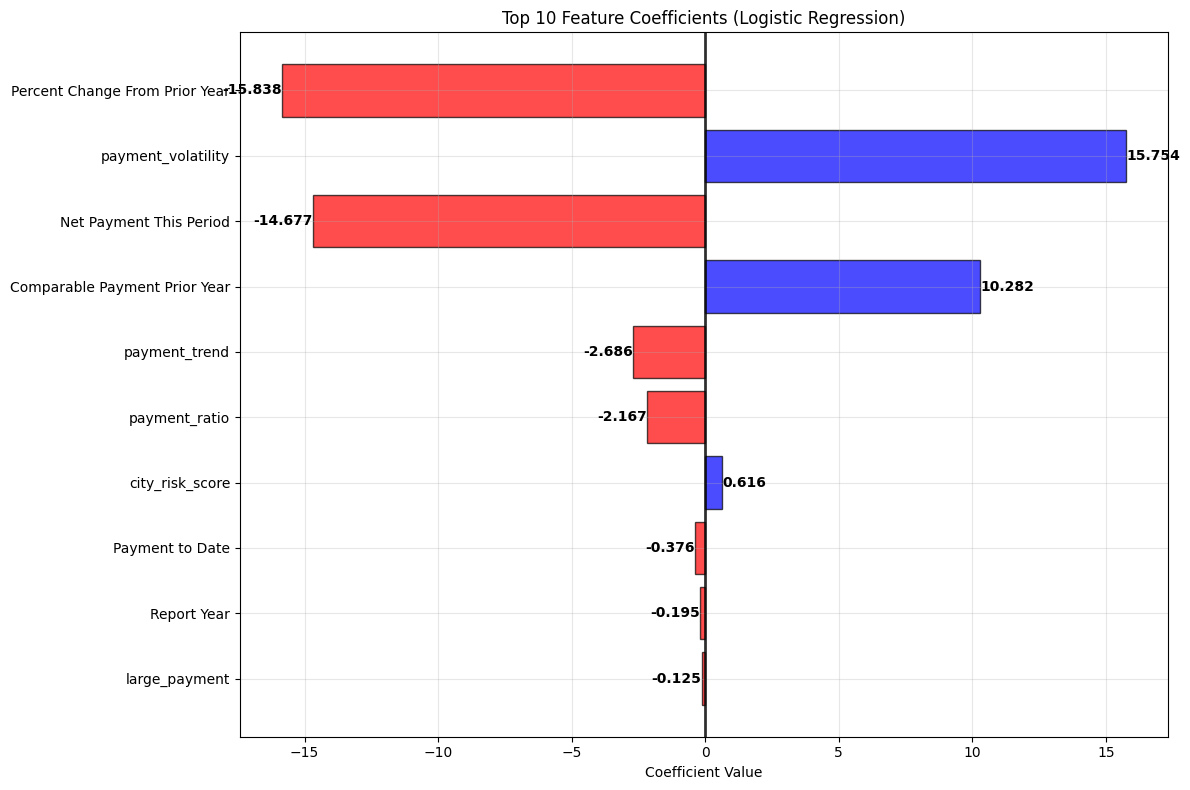

In [ ]:
# Create feature importance for Logistic Regression
feature_importance_lr = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0],
    'abs_coefficient': np.abs(lr_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("Top 10 Most Important Features (Logistic Regression):")
for i, row in feature_importance_lr.head(10).iterrows():
    print(f"{i+1:2d}. {row['feature']:<30}: {row['coefficient']:.4f}")

# Feature importance visualization
plt.figure(figsize=(12, 8))
top_features_lr = feature_importance_lr.head(10)
colors = ['red' if coef < 0 else 'blue' for coef in top_features_lr['coefficient']]
bars = plt.barh(range(len(top_features_lr)), top_features_lr['coefficient'],
                color=colors, alpha=0.7, edgecolor='black')

plt.yticks(range(len(top_features_lr)), top_features_lr['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Coefficients (Logistic Regression)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.8, linewidth=2)

# Add value labels
for i, (coef, bar) in enumerate(zip(top_features_lr['coefficient'], bars)):
    plt.text(coef + (0.01 if coef >= 0 else -0.01), i, f'{coef:.3f}',
             va='center', ha='left' if coef >= 0 else 'right', fontweight='bold')

plt.tight_layout()
plt.show()

#Intelligence dashboards


In [ ]:
print(f"\nCity-wise Risk Analysis")
city_risk_summary = df.groupby('City').agg({
    'default_risk': ['count', 'sum', 'mean'],
    'Net Payment This Period': 'sum',
    'Percent Change From Prior Year': 'mean'
}).round(3)

city_risk_summary.columns = ['Total_Records', 'Default_Cases', 'Default_Rate',
                            'Total_Payments', 'Avg_Change_Rate']
city_risk_summary = city_risk_summary.sort_values('Default_Rate', ascending=False)

print("Top 10 Highest Risk Cities:")
for i, (city, row) in enumerate(city_risk_summary.head(10).iterrows(), 1):
    print(f"{i:2d}. {city:<20}: {row['Default_Rate']:.1%} default rate ({row['Default_Cases']:.0f}/{row['Total_Records']:.0f})")


City-wise Risk Analysis
Top 10 Highest Risk Cities:
 1. Brock West          : 72.7% default rate (24/33)
 2. Lincoln Park        : 40.0% default rate (24/60)
 3. Forsan              : 33.1% default rate (50/151)
 4. Ames                : 33.1% default rate (50/151)
 5. Impact              : 32.5% default rate (49/151)
 6. Thompsons           : 31.8% default rate (48/151)
 7. Asherton            : 31.8% default rate (48/151)
 8. Draper              : 31.0% default rate (22/71)
 9. Huxley              : 30.5% default rate (46/151)
10. Southmayd           : 29.8% default rate (45/151)



 City-wise Risk Analysis
Top 10 Highest Risk Cities:
 1. Brock West          : 72.7% default rate (24/33)
 2. Lincoln Park        : 40.0% default rate (24/60)
 3. Forsan              : 33.1% default rate (50/151)
 4. Ames                : 33.1% default rate (50/151)
 5. Impact              : 32.5% default rate (49/151)
 6. Thompsons           : 31.8% default rate (48/151)
 7. Asherton            : 31.8% default rate (48/151)
 8. Draper              : 31.0% default rate (22/71)
 9. Huxley              : 30.5% default rate (46/151)
10. Southmayd           : 29.8% default rate (45/151)

Visual Business Intelligence Dashboard


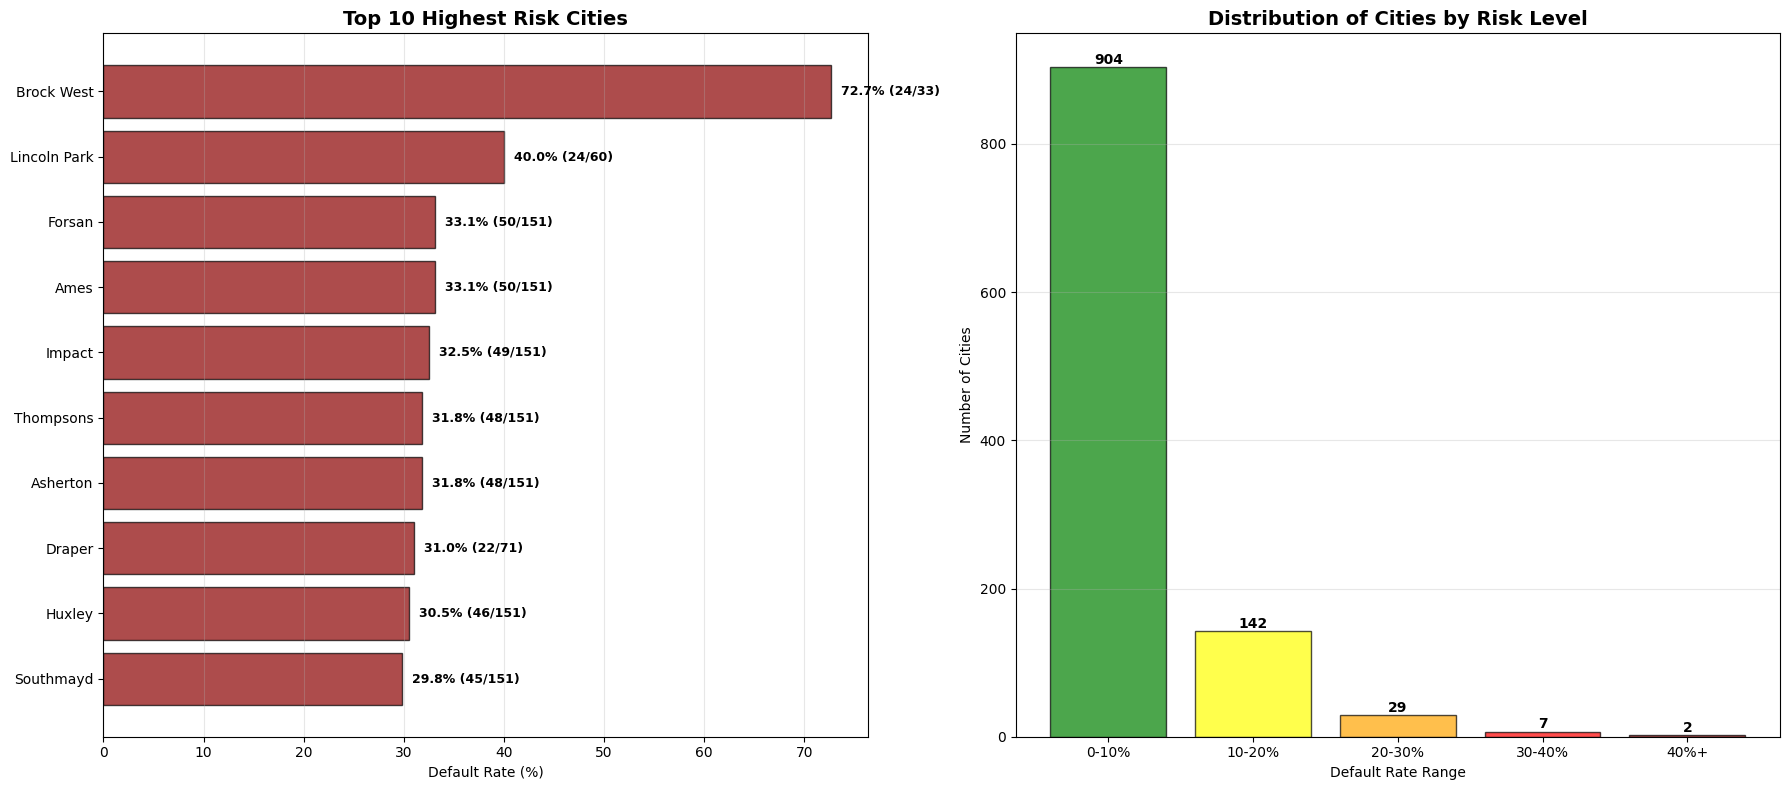

In [ ]:
print(f"\n City-wise Risk Analysis")
city_risk_summary = df.groupby('City').agg({
    'default_risk': ['count', 'sum', 'mean'],
    'Net Payment This Period': 'sum',
    'Percent Change From Prior Year': 'mean'
}).round(3)

city_risk_summary.columns = ['Total_Records', 'Default_Cases', 'Default_Rate',
                            'Total_Payments', 'Avg_Change_Rate']
city_risk_summary = city_risk_summary.sort_values('Default_Rate', ascending=False)

print("Top 10 Highest Risk Cities:")
for i, (city, row) in enumerate(city_risk_summary.head(10).iterrows(), 1):
    print(f"{i:2d}. {city:<20}: {row['Default_Rate']:.1%} default rate ({row['Default_Cases']:.0f}/{row['Total_Records']:.0f})")

print(f"\nVisual Business Intelligence Dashboard")

# Dashboard Layout 1: Top Cities and Risk Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left: Top 10 Highest Risk Cities
top_10_cities = city_risk_summary.head(10)
bars1 = ax1.barh(range(len(top_10_cities)), top_10_cities['Default_Rate']*100,
                 color='darkred', alpha=0.7, edgecolor='black')

ax1.set_yticks(range(len(top_10_cities)))
ax1.set_yticklabels(top_10_cities.index)
ax1.set_xlabel('Default Rate (%)')
ax1.set_title('Top 10 Highest Risk Cities', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_10_cities.iterrows()):
    rate = row['Default_Rate']*100
    cases = row['Default_Cases']
    total = row['Total_Records']
    ax1.text(rate + 1, i, f'{rate:.1f}% ({cases:.0f}/{total:.0f})',
             va='center', fontweight='bold', fontsize=9)

# Right: City Risk Distribution
risk_ranges = ['0-10%', '10-20%', '20-30%', '30-40%', '40%+']
range_counts = [
    len(city_risk_summary[(city_risk_summary['Default_Rate'] >= 0) & (city_risk_summary['Default_Rate'] < 0.1)]),
    len(city_risk_summary[(city_risk_summary['Default_Rate'] >= 0.1) & (city_risk_summary['Default_Rate'] < 0.2)]),
    len(city_risk_summary[(city_risk_summary['Default_Rate'] >= 0.2) & (city_risk_summary['Default_Rate'] < 0.3)]),
    len(city_risk_summary[(city_risk_summary['Default_Rate'] >= 0.3) & (city_risk_summary['Default_Rate'] < 0.4)]),
    len(city_risk_summary[city_risk_summary['Default_Rate'] >= 0.4])
]

colors = ['green', 'yellow', 'orange', 'red', 'darkred']
bars2 = ax2.bar(risk_ranges, range_counts, color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Default Rate Range')
ax2.set_ylabel('Number of Cities')
ax2.set_title('Distribution of Cities by Risk Level', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, count in zip(bars2, range_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.3, f'{count}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


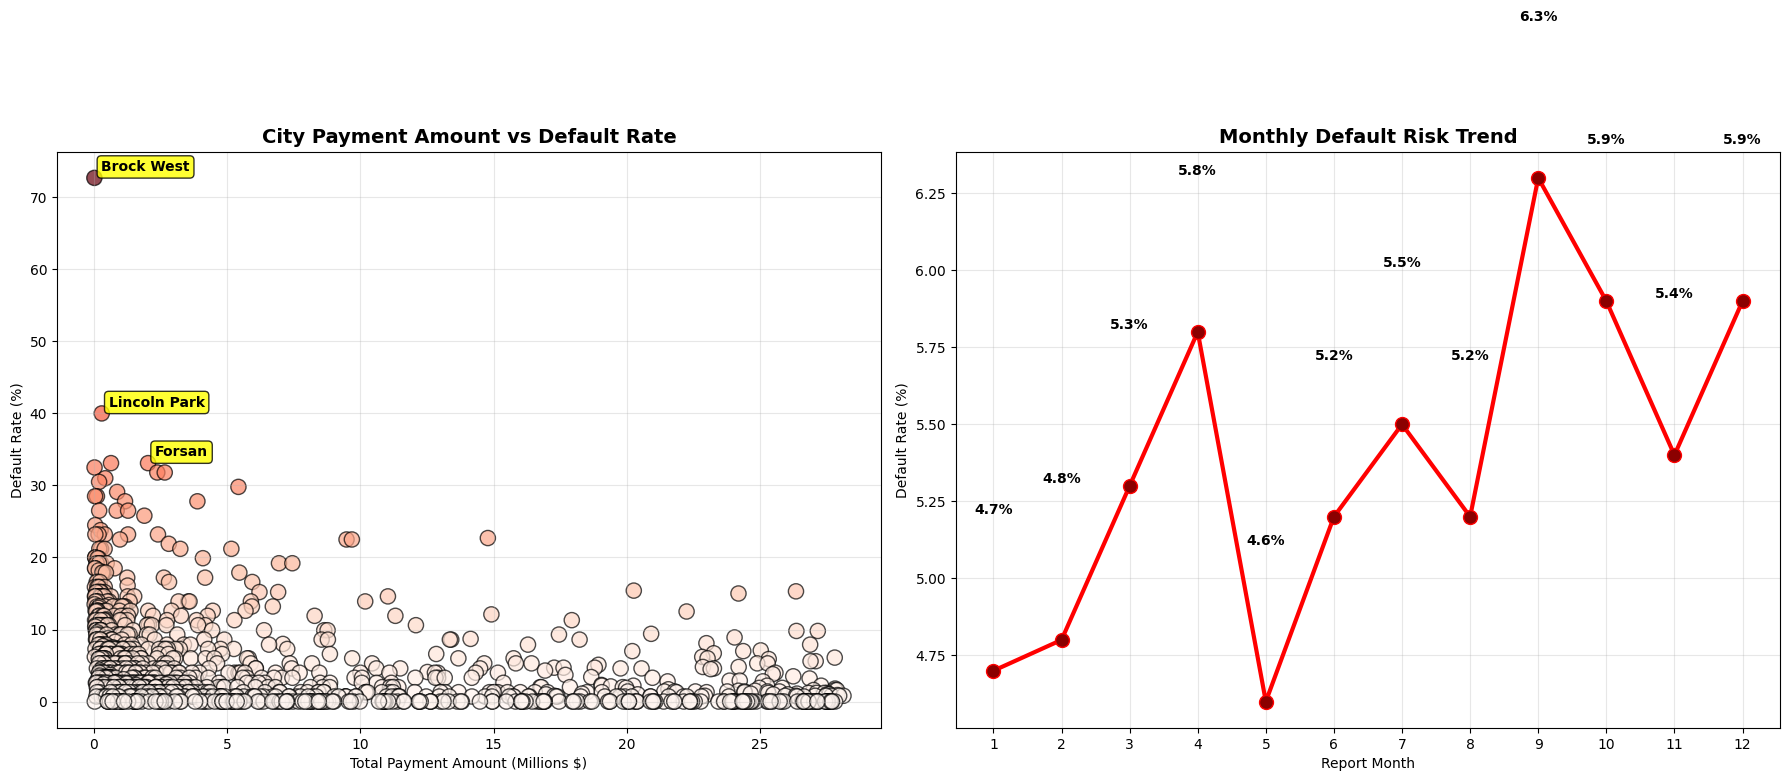

In [ ]:
# Dashboard Layout 2: Payment Analysis and Monthly Trends
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left: Payment Amount vs Default Rate Scatter Plot
scatter = ax1.scatter(city_risk_summary['Total_Payments']/1000000,
                      city_risk_summary['Default_Rate']*100,  # Convert to percentage
                      c=city_risk_summary['Default_Rate']*100,
                      cmap='Reds', alpha=0.7, s=120, edgecolors='black')

ax1.set_xlabel('Total Payment Amount (Millions $)')
ax1.set_ylabel('Default Rate (%)')
ax1.set_title('City Payment Amount vs Default Rate', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Annotate top 3 risk cities
for i, (city, row) in enumerate(city_risk_summary.head(3).iterrows()):
    ax1.annotate(city,
                (row['Total_Payments']/1000000, row['Default_Rate']*100),
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))

#  Monthly Risk Trends
monthly_risk = df.groupby('Report Month').agg({
    'default_risk': ['count', 'sum', 'mean'],
    'Net Payment This Period': 'mean'
}).round(3)

monthly_risk.columns = ['Total_Records', 'Default_Cases', 'Default_Rate', 'Avg_Payment']

ax2.plot(monthly_risk.index, monthly_risk['Default_Rate']*100,
         marker='o', linewidth=3, markersize=10, color='red', markerfacecolor='darkred')
ax2.set_xlabel('Report Month')
ax2.set_ylabel('Default Rate (%)')
ax2.set_title('Monthly Default Risk Trend', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(1, 13))

# Add value labels
for month, rate in zip(monthly_risk.index, monthly_risk['Default_Rate']*100):
    ax2.text(month, rate + 0.5, f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



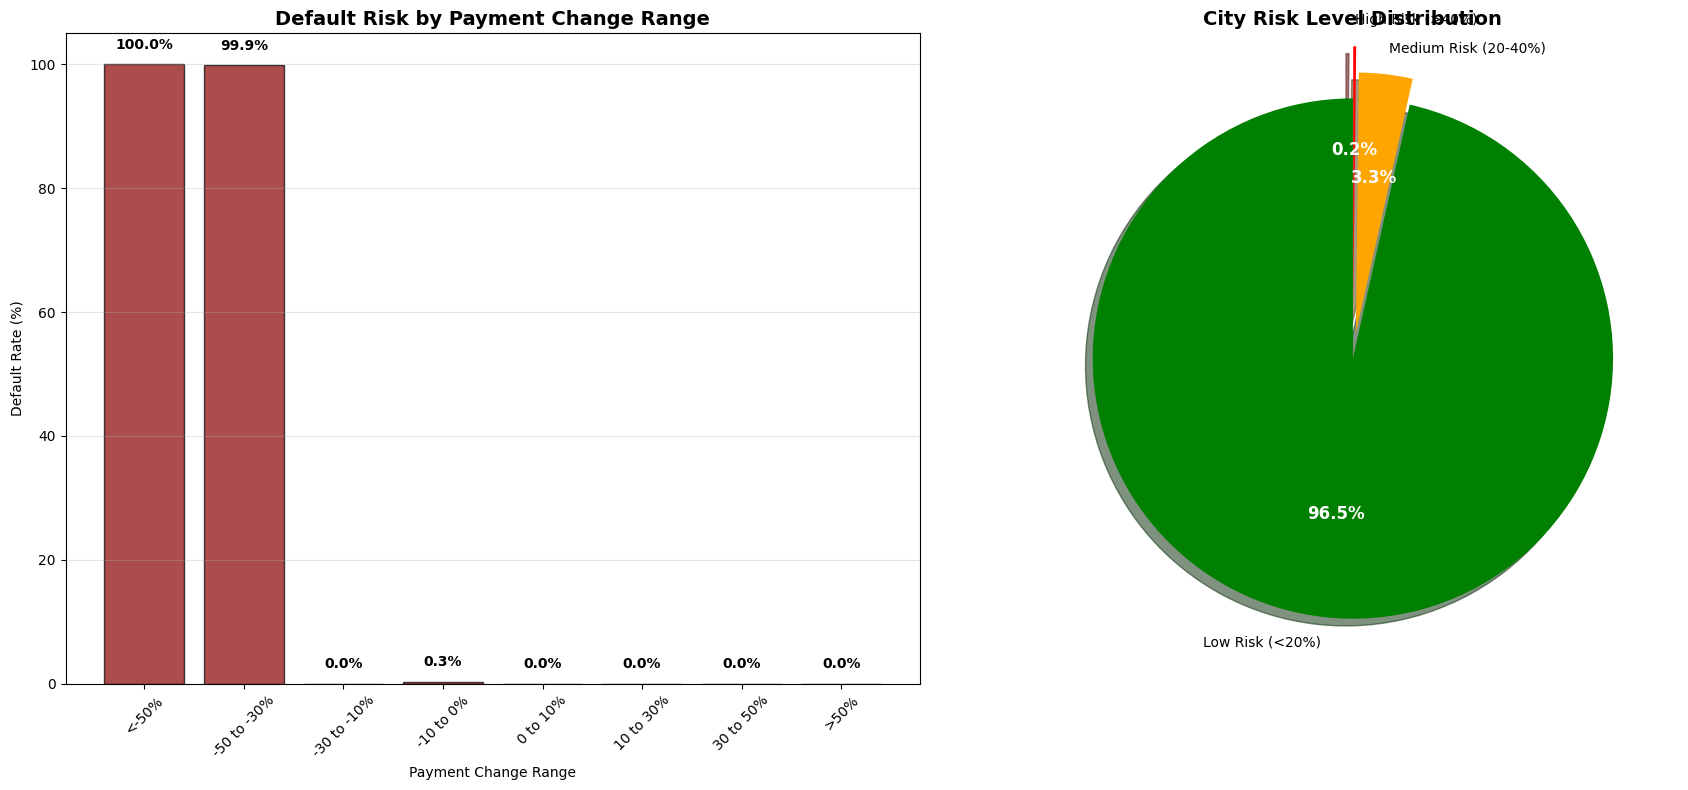

In [ ]:
# Dashboard Layout 3: Payment Change Analysis and Risk Summary
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left: Payment Change vs Default Risk
change_bins = [-100, -50, -30, -10, 0, 10, 30, 50, 100]
change_labels = ['<-50%', '-50 to -30%', '-30 to -10%', '-10 to 0%',
                '0 to 10%', '10 to 30%', '30 to 50%', '>50%']

df['change_bin'] = pd.cut(df['Percent Change From Prior Year'],
                         bins=change_bins, labels=change_labels, include_lowest=True)

heatmap_data = df.groupby('change_bin')['default_risk'].agg(['count', 'sum', 'mean']).round(3)
heatmap_data.columns = ['Total_Cases', 'Default_Cases', 'Default_Rate']

bars3 = ax1.bar(range(len(heatmap_data)), heatmap_data['Default_Rate']*100,
                color='darkred', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Payment Change Range')
ax1.set_ylabel('Default Rate (%)')
ax1.set_title('Default Risk by Payment Change Range', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(heatmap_data)))
ax1.set_xticklabels(heatmap_data.index, rotation=45)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, rate in enumerate(heatmap_data['Default_Rate']*100):
    ax1.text(i, rate + 2, f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

# Right: Risk Distribution Pie Chart
risk_low = len(city_risk_summary[city_risk_summary['Default_Rate'] < 0.2])
risk_medium = len(city_risk_summary[(city_risk_summary['Default_Rate'] >= 0.2) &
                                   (city_risk_summary['Default_Rate'] < 0.4)])
risk_high = len(city_risk_summary[city_risk_summary['Default_Rate'] >= 0.4])

sizes = [risk_low, risk_medium, risk_high]
labels = ['Low Risk (<20%)', 'Medium Risk (20-40%)', 'High Risk (>40%)']
colors_pie = ['green', 'orange', 'red']
explode = (0, 0.1, 0.2)

wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%',
                                  explode=explode, shadow=True, startangle=90)
ax2.set_title('City Risk Level Distribution', fontsize=14, fontweight='bold')

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

plt.tight_layout()
plt.show()

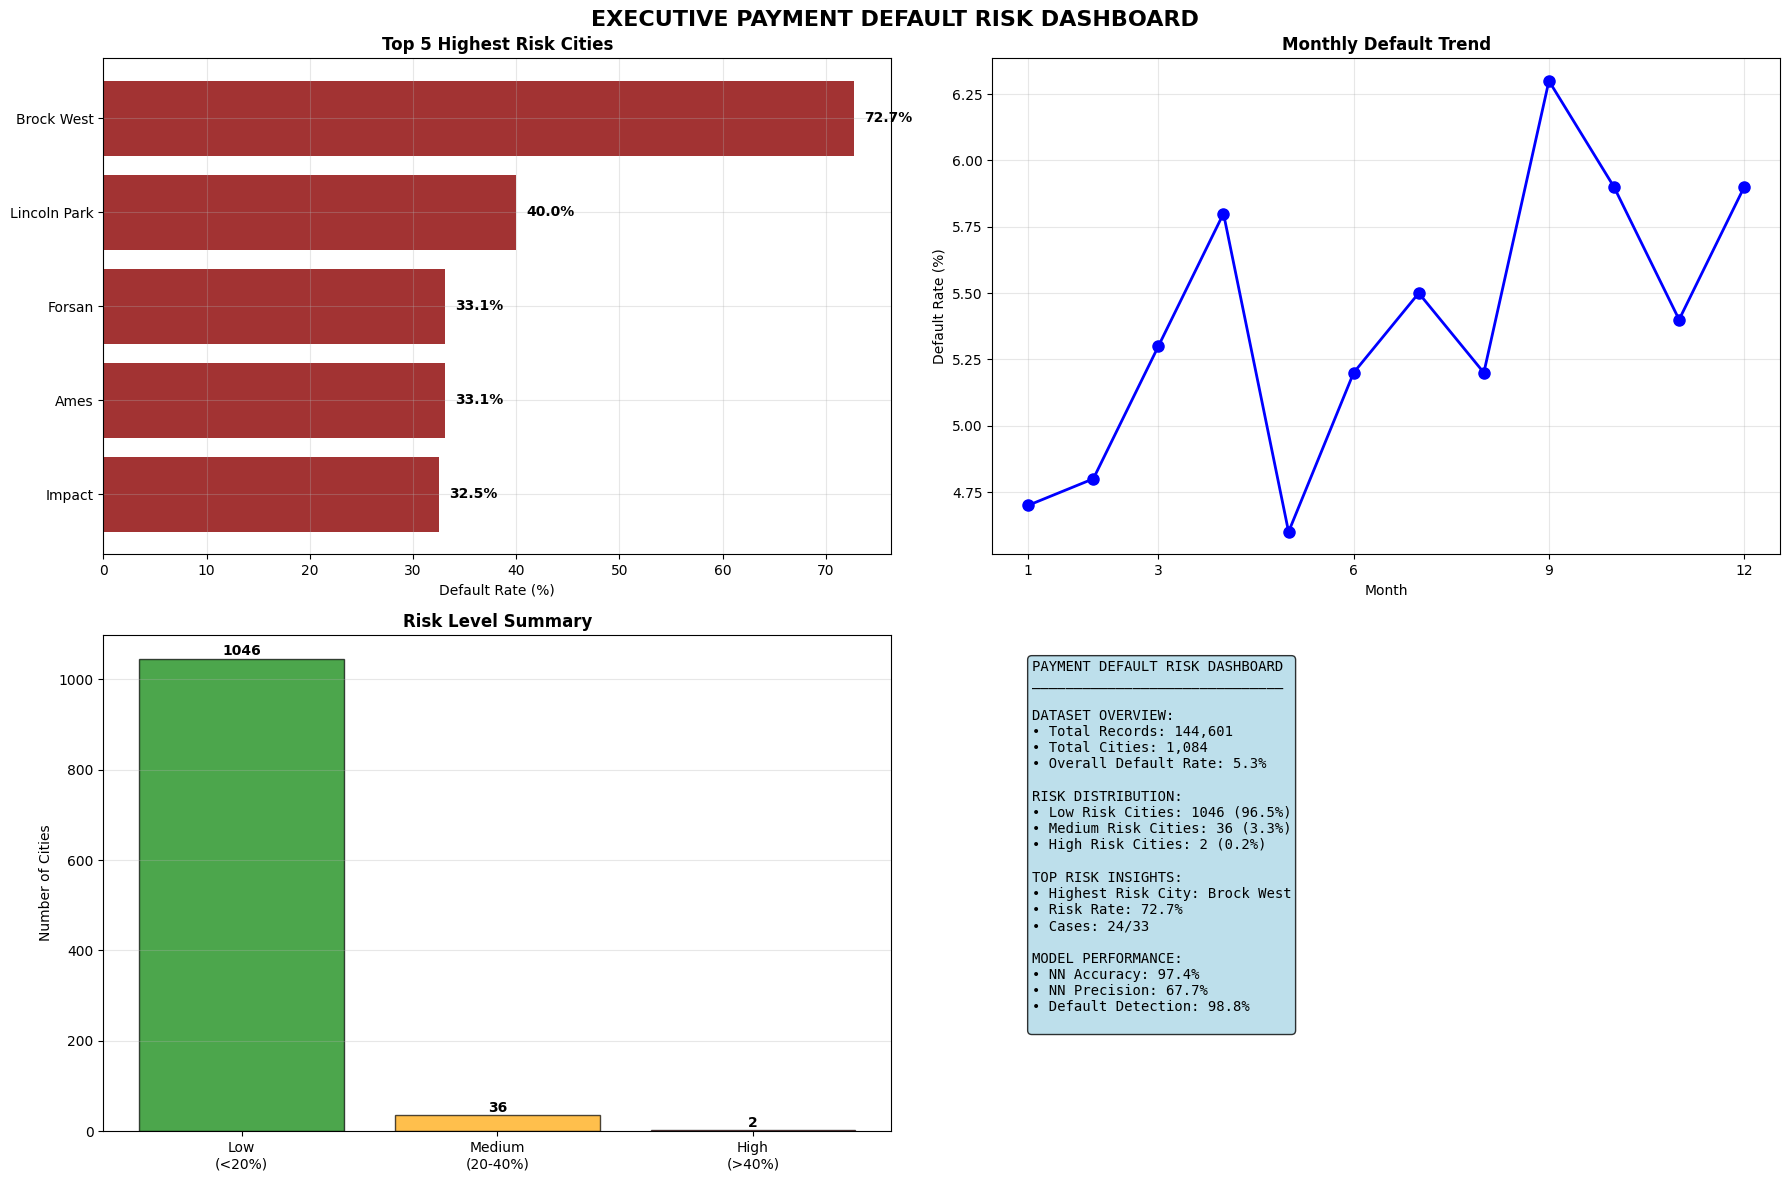

In [ ]:
# Dashboard Layout 4: Executive Summary Dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Top 5 Cities Quick View
top_5 = city_risk_summary.head(5)
bars4 = ax1.barh(range(len(top_5)), top_5['Default_Rate']*100, color='darkred', alpha=0.8)
ax1.set_yticks(range(len(top_5)))
ax1.set_yticklabels(top_5.index)
ax1.set_xlabel('Default Rate (%)')
ax1.set_title('Top 5 Highest Risk Cities', fontweight='bold', fontsize=12)
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)

for i, rate in enumerate(top_5['Default_Rate']*100):
    ax1.text(rate + 1, i, f'{rate:.1f}%', va='center', fontweight='bold')

# Monthly Trend (Compact)
ax2.plot(monthly_risk.index, monthly_risk['Default_Rate']*100,
         marker='o', linewidth=2, markersize=8, color='blue')
ax2.set_xlabel('Month')
ax2.set_ylabel('Default Rate (%)')
ax2.set_title('Monthly Default Trend', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xticks([1, 3, 6, 9, 12])

# Risk Level Summary
risk_data = [risk_low, risk_medium, risk_high]
risk_labels = ['Low\n(<20%)', 'Medium\n(20-40%)', 'High\n(>40%)']
colors_bar = ['green', 'orange', 'red']

bars5 = ax3.bar(risk_labels, risk_data, color=colors_bar, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Number of Cities')
ax3.set_title('Risk Level Summary', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars5, risk_data):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{count}',
             ha='center', va='bottom', fontweight='bold')

# Key Metrics Summary
stats_text = f"""PAYMENT DEFAULT RISK DASHBOARD
______________________________

DATASET OVERVIEW:
• Total Records: {len(df):,}
• Total Cities: {df['City'].nunique():,}
• Overall Default Rate: {df['default_risk'].mean():.1%}

RISK DISTRIBUTION:
• Low Risk Cities: {risk_low} ({risk_low/len(city_risk_summary)*100:.1f}%)
• Medium Risk Cities: {risk_medium} ({risk_medium/len(city_risk_summary)*100:.1f}%)
• High Risk Cities: {risk_high} ({risk_high/len(city_risk_summary)*100:.1f}%)

TOP RISK INSIGHTS:
• Highest Risk City: {city_risk_summary.index[0]}
• Risk Rate: {city_risk_summary.iloc[0]['Default_Rate']:.1%}
• Cases: {city_risk_summary.iloc[0]['Default_Cases']:.0f}/{city_risk_summary.iloc[0]['Total_Records']:.0f}

MODEL PERFORMANCE:
• NN Accuracy: {accuracy:.1%}
• NN Precision: {precision:.1%}
• Default Detection: {recall:.1%}
"""

ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.axis('off')

plt.suptitle('EXECUTIVE PAYMENT DEFAULT RISK DASHBOARD', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()